In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [9]:
from utilities.userfold_framework import *
from utilities.EEG_func import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
# import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

class LSTM_output(torch.nn.Module):
    def forward(self, x):
        return x[0].unsqueeze(0)


for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run1"
    nonlinear_func= torch.nn.Sequential(
#                     LSTM_input(),
                    torch.nn.LSTM(input_dim[1],input_dim[1]),
                    LSTM_output(),
                    torch.nn.Sigmoid(),
#                     EEGNet_input()
                        ).to(DEVICE)
    model = EEGNet_NeuralFS_EEG_Wrapper(DEVICE, classifier, input_dim[0],
                                nonlinear_func=nonlinear_func
                                 ).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
    train_func= eeg_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-NFS_EEG-e{EPOCH}.pt"
           )
    )

    pickle.dump( model.return_pairwise_weights(), 
                open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-NFS_EEG-w-e{EPOCH}.pkl", "wb") 
               )    

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-NFS_EEG-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )
#     pickle.load( 
#                 open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-NFS_EEG-w-e{EPOCH}.pkl", "rb") 
#                )  
    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6808966480049432


Iterations:   0%|                                   | 1/300 [00:01<06:14,  1.25s/it]

Epoch:  0
t_loss:  0.6808966480049432 , v_loss:  0.6951198975245158
t_acc:  0.5294117647058824 , v_acc:  0.32919254658385094
t_recall:  0.49296262746874187 , v_recall:  0.5135135135135135
t_prec:  0.49383825525185343 , v_prec:  0.6582278481012658
t_f:  0.4874823923008041 , v_f:  0.26670040485829966
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:51,  1.02it/s]

Epoch  1 , loss 0.6509783735462263
Epoch  2 , loss 0.6284201519162047


Iterations:   1%|▎                                  | 3/300 [00:03<05:25,  1.10s/it]

Epoch:  2
t_loss:  0.6284201519162047 , v_loss:  0.6967721780141195
t_acc:  0.6056644880174292 , v_acc:  0.3416149068322981
t_recall:  0.48940311003142967 , v_recall:  0.5225225225225225
t_prec:  0.4863298355779559 , v_prec:  0.6602564102564102
t_f:  0.48197657838950564 , v_f:  0.28582189487780385
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:46,  1.03it/s]

Epoch  3 , loss 0.6079125883532506
Epoch  4 , loss 0.5888318863569522


Iterations:   2%|▌                                  | 5/300 [00:05<05:14,  1.07s/it]

Epoch:  4
t_loss:  0.5888318863569522 , v_loss:  0.6897605856259664
t_acc:  0.6579520697167756 , v_acc:  0.546583850931677
t_recall:  0.504846900262143 , v_recall:  0.5118018018018018
t_prec:  0.5107622840076798 , v_prec:  0.5104967948717949
t_f:  0.47638768303180523 , v_f:  0.5062801932367149
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:44,  1.03it/s]

Epoch  5 , loss 0.5682400126083225
Epoch  6 , loss 0.5545152227083842


Iterations:   2%|▊                                  | 7/300 [00:07<05:12,  1.07s/it]

Epoch:  6
t_loss:  0.5545152227083842 , v_loss:  0.6722949147224426
t_acc:  0.683162153750389 , v_acc:  0.6645962732919255
t_recall:  0.5062907453919107 , v_recall:  0.492972972972973
t_prec:  0.5307080231005266 , v_prec:  0.4681372549019608
t_f:  0.4511515160464526 , v_f:  0.43221003134796243
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:43,  1.03it/s]

Epoch  7 , loss 0.5422056317329407
Epoch  8 , loss 0.5289758063998877


Iterations:   3%|█                                  | 9/300 [00:09<05:03,  1.04s/it]

Epoch:  8
t_loss:  0.5289758063998877 , v_loss:  0.6576227943102518
t_acc:  0.6872082166199813 , v_acc:  0.6832298136645962
t_recall:  0.4994228736910007 , v_recall:  0.4954954954954955
t_prec:  0.49383491349819175 , v_prec:  0.34375
t_f:  0.4248672492447638 , v_f:  0.40590405904059035
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:38,  1.04it/s]

Epoch  9 , loss 0.51594952508515
Epoch  10 , loss 0.5079295091769275


Iterations:   4%|█▏                                | 11/300 [00:11<05:03,  1.05s/it]

Epoch:  10
t_loss:  0.5079295091769275 , v_loss:  0.6523386836051941
t_acc:  0.686896981014628 , v_acc:  0.6894409937888198
t_recall:  0.4968988896666255 , v_recall:  0.5
t_prec:  0.4571387922858046 , v_prec:  0.3447204968944099
t_f:  0.4175177288605234 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:42,  1.02it/s]

Epoch  11 , loss 0.4998290550475027
Epoch  12 , loss 0.497840740517074


Iterations:   4%|█▍                                | 13/300 [00:13<05:13,  1.09s/it]

Epoch:  12
t_loss:  0.497840740517074 , v_loss:  0.654409130414327
t_acc:  0.6934329287270464 , v_acc:  0.6894409937888198
t_recall:  0.5015968762438067 , v_recall:  0.5
t_prec:  0.5378021573384162 , v_prec:  0.3447204968944099
t_f:  0.42003960832944076 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:14<05:00,  1.05s/it]

Epoch  13 , loss 0.4854492194512311
Epoch  14 , loss 0.47873393636123807


Iterations:   5%|█▋                                | 15/300 [00:15<05:27,  1.15s/it]

Epoch:  14
t_loss:  0.47873393636123807 , v_loss:  0.6580163836479187
t_acc:  0.6937441643323996 , v_acc:  0.6894409937888198
t_recall:  0.5000953871069571 , v_recall:  0.5
t_prec:  0.5040760869565217 , v_prec:  0.3447204968944099
t_f:  0.41445580700699036 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:16<05:11,  1.10s/it]

Epoch  15 , loss 0.47511960010902554
Epoch  16 , loss 0.46942175077457055


Iterations:   6%|█▉                                | 17/300 [00:18<05:32,  1.17s/it]

Epoch:  16
t_loss:  0.46942175077457055 , v_loss:  0.6633448799451193
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5026838775202097 , v_recall:  0.5
t_prec:  0.6665578331724491 , v_prec:  0.3447204968944099
t_f:  0.4174144390948958 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:19<05:10,  1.10s/it]

Epoch  17 , loss 0.46808580148453804
Epoch  18 , loss 0.4643130542016497


Iterations:   6%|██▏                               | 19/300 [00:20<05:27,  1.17s/it]

Epoch:  18
t_loss:  0.4643130542016497 , v_loss:  0.6662898461023966
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.49910514541387024 , v_recall:  0.5
t_prec:  0.347616079775631 , v_prec:  0.3447204968944099
t_f:  0.40980896399706096 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:21<05:01,  1.08s/it]

Epoch  19 , loss 0.46239540974299115
Epoch  20 , loss 0.45686304043321047


Iterations:   7%|██▍                               | 21/300 [00:22<05:25,  1.17s/it]

Epoch:  20
t_loss:  0.45686304043321047 , v_loss:  0.6698378423849741
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:56,  1.07s/it]

Epoch  21 , loss 0.4576934850683399
Epoch  22 , loss 0.45058828942915974


Iterations:   8%|██▌                               | 23/300 [00:24<05:13,  1.13s/it]

Epoch:  22
t_loss:  0.45058828942915974 , v_loss:  0.6729439198970795
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.49961639285763304 , v_recall:  0.5
t_prec:  0.44772443890274316 , v_prec:  0.3447204968944099
t_f:  0.4109015490043957 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:45,  1.03s/it]

Epoch  23 , loss 0.44362987899312784
Epoch  24 , loss 0.45273347929412244


Iterations:   8%|██▊                               | 25/300 [00:26<05:01,  1.10s/it]

Epoch:  24
t_loss:  0.45273347929412244 , v_loss:  0.6735316117604574
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5002875337972303 , v_recall:  0.5
t_prec:  0.5978667081905948 , v_prec:  0.3447204968944099
t_f:  0.4112297361103825 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:27<04:37,  1.01s/it]

Epoch  25 , loss 0.44699366069307517
Epoch  26 , loss 0.44965962861098496


Iterations:   9%|███                               | 27/300 [00:28<05:00,  1.10s/it]

Epoch:  26
t_loss:  0.44965962861098496 , v_loss:  0.674214760462443
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5002875337972303 , v_recall:  0.5
t_prec:  0.5978667081905948 , v_prec:  0.3447204968944099
t_f:  0.4112297361103825 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:29<04:46,  1.05s/it]

Epoch  27 , loss 0.4449356356087853
Epoch  28 , loss 0.4484553471499798


Iterations:  10%|███▎                              | 29/300 [00:31<04:57,  1.10s/it]

Epoch:  28
t_loss:  0.4484553471499798 , v_loss:  0.6724819342295328
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8480224229212083 , v_prec:  0.3447204968944099
t_f:  0.4124337652798909 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:32<04:46,  1.06s/it]

Epoch  29 , loss 0.4450148437537399
Epoch  30 , loss 0.440469002606822


Iterations:  10%|███▌                              | 31/300 [00:33<04:58,  1.11s/it]

Epoch:  30
t_loss:  0.440469002606822 , v_loss:  0.6721335848172506
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5007987812409931 , v_recall:  0.5
t_prec:  0.6813084112149532 , v_prec:  0.3447204968944099
t_f:  0.41232340081380947 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:34<04:54,  1.10s/it]

Epoch  31 , loss 0.4426709466120776
Epoch  32 , loss 0.4476672504462448


Iterations:  11%|███▋                              | 33/300 [00:35<05:02,  1.13s/it]

Epoch:  32
t_loss:  0.4476672504462448 , v_loss:  0.6690921783447266
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5002875337972303 , v_recall:  0.5
t_prec:  0.5978667081905948 , v_prec:  0.3447204968944099
t_f:  0.4112297361103825 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:36<04:48,  1.09s/it]

Epoch  33 , loss 0.4450915940836364
Epoch  34 , loss 0.44188781813079236


Iterations:  12%|███▉                              | 35/300 [00:37<05:00,  1.14s/it]

Epoch:  34
t_loss:  0.44188781813079236 , v_loss:  0.6671210378408432
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.500862601391691 , v_recall:  0.5
t_prec:  0.5979887745556596 , v_prec:  0.3447204968944099
t_f:  0.4131921101460188 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:38<04:43,  1.08s/it]

Epoch  35 , loss 0.44004792091893213
Epoch  36 , loss 0.43729546315529766


Iterations:  12%|████▏                             | 37/300 [00:40<04:58,  1.14s/it]

Epoch:  36
t_loss:  0.43729546315529766 , v_loss:  0.6638973752657572
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5001276403013958 , v_recall:  0.5
t_prec:  0.5144995322731525 , v_prec:  0.3447204968944099
t_f:  0.41199209401134806 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:40<04:32,  1.04s/it]

Epoch  37 , loss 0.4380105909179239
Epoch  38 , loss 0.4380066868136911


Iterations:  13%|████▍                             | 39/300 [00:42<04:52,  1.12s/it]

Epoch:  38
t_loss:  0.4380066868136911 , v_loss:  0.6597670068343481
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8480224229212083 , v_prec:  0.3447204968944099
t_f:  0.4124337652798909 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:42<04:28,  1.03s/it]

Epoch  39 , loss 0.43932419781591375
Epoch  40 , loss 0.4382699581922269


Iterations:  14%|████▋                             | 41/300 [00:44<04:54,  1.14s/it]

Epoch:  40
t_loss:  0.4382699581922269 , v_loss:  0.6528426806131998
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5015975624819863 , v_recall:  0.5
t_prec:  0.6814780168381664 , v_prec:  0.3447204968944099
t_f:  0.4143921262806895 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:45<04:25,  1.03s/it]

Epoch  41 , loss 0.4391806768436058
Epoch  42 , loss 0.4335820698270611


Iterations:  14%|████▊                             | 43/300 [00:46<04:56,  1.15s/it]

Epoch:  42
t_loss:  0.4335820698270611 , v_loss:  0.6436670223871866
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.500063820150698 , v_recall:  0.5
t_prec:  0.5144859813084112 , v_prec:  0.3447204968944099
t_f:  0.4111203780928551 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:47<04:26,  1.04s/it]

Epoch  43 , loss 0.4397227775816824
Epoch  44 , loss 0.43250073638616826


Iterations:  15%|█████                             | 45/300 [00:48<04:53,  1.15s/it]

Epoch:  44
t_loss:  0.43250073638616826 , v_loss:  0.636513908704122
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5015975624819863 , v_recall:  0.5
t_prec:  0.6814780168381664 , v_prec:  0.3447204968944099
t_f:  0.4143921262806895 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:49<04:22,  1.03s/it]

Epoch  45 , loss 0.43033213212209587
Epoch  46 , loss 0.43253355224927265


Iterations:  16%|█████▎                            | 47/300 [00:50<04:46,  1.13s/it]

Epoch:  46
t_loss:  0.43253355224927265 , v_loss:  0.6295348058144251
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5011501351889214 , v_recall:  0.5
t_prec:  0.5980499219968799 , v_prec:  0.3447204968944099
t_f:  0.41416708924949286 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:51<04:17,  1.02s/it]

Epoch  47 , loss 0.4322150764512081
Epoch  48 , loss 0.4255140786077462


Iterations:  16%|█████▌                            | 49/300 [00:53<04:41,  1.12s/it]

Epoch:  48
t_loss:  0.4255140786077462 , v_loss:  0.6221390962600708
t_acc:  0.6962340491752257 , v_acc:  0.6956521739130435
t_recall:  0.5024601638736773 , v_recall:  0.51
t_prec:  0.6399953139643861 , v_prec:  0.846875
t_f:  0.4172988159743127 , v_f:  0.42920193907821425
////////


Iterations:  17%|█████▋                            | 50/300 [00:53<04:13,  1.01s/it]

Epoch  49 , loss 0.4280000580292122
Epoch  50 , loss 0.42449453180911495


Iterations:  17%|█████▊                            | 51/300 [00:55<04:36,  1.11s/it]

Epoch:  50
t_loss:  0.42449453180911495 , v_loss:  0.619939332207044
t_acc:  0.6949891067538126 , v_acc:  0.6956521739130435
t_recall:  0.5015653092875475 , v_recall:  0.51
t_prec:  0.5668888802001877 , v_prec:  0.846875
t_f:  0.41683606795411643 , v_f:  0.42920193907821425
////////


Iterations:  17%|█████▉                            | 52/300 [00:55<04:08,  1.00s/it]

Epoch  51 , loss 0.426574673722772
Epoch  52 , loss 0.42314690351486206


Iterations:  18%|██████                            | 53/300 [00:57<04:27,  1.08s/it]

Epoch:  52
t_loss:  0.42314690351486206 , v_loss:  0.6134506613016129
t_acc:  0.6984126984126984 , v_acc:  0.6956521739130435
t_recall:  0.5051762945883257 , v_recall:  0.51
t_prec:  0.7719831730769231 , v_prec:  0.846875
t_f:  0.42195546486919533 , v_f:  0.42920193907821425
////////


Iterations:  18%|██████                            | 54/300 [00:57<04:08,  1.01s/it]

Epoch  53 , loss 0.4231065535077862
Epoch  54 , loss 0.42318711152263716


Iterations:  18%|██████▏                           | 55/300 [00:59<04:28,  1.10s/it]

Epoch:  54
t_loss:  0.42318711152263716 , v_loss:  0.6092992971340815
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5034826587612028 , v_recall:  0.5054954954954954
t_prec:  0.6699749921850578 , v_prec:  0.5959119496855345
t_f:  0.4194516752347822 , v_f:  0.4266381766381766
////////


Iterations:  19%|██████▎                           | 56/300 [01:00<04:08,  1.02s/it]

Epoch  55 , loss 0.4256053724709679
Epoch  56 , loss 0.4231191739147785


Iterations:  19%|██████▍                           | 57/300 [01:01<04:25,  1.09s/it]

Epoch:  56
t_loss:  0.4231191739147785 , v_loss:  0.6039829949537913
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5039300860542677 , v_recall:  0.5054954954954954
t_prec:  0.7236410496719775 , v_prec:  0.5959119496855345
t_f:  0.4196869355809753 , v_f:  0.4266381766381766
////////


Iterations:  19%|██████▌                           | 58/300 [01:02<04:15,  1.06s/it]

Epoch  57 , loss 0.42343143213029
Epoch  58 , loss 0.4220460250097163


Iterations:  20%|██████▋                           | 59/300 [01:03<04:35,  1.14s/it]

Epoch:  58
t_loss:  0.4220460250097163 , v_loss:  0.5981564621130625
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5036102990625986 , v_recall:  0.5054954954954954
t_prec:  0.6235750078296274 , v_prec:  0.5959119496855345
t_f:  0.42111784364602456 , v_f:  0.4266381766381766
////////


Iterations:  20%|██████▊                           | 60/300 [01:04<04:24,  1.10s/it]

Epoch  59 , loss 0.42162665549446554
Epoch  60 , loss 0.41526345937859777


Iterations:  20%|██████▉                           | 61/300 [01:06<04:45,  1.19s/it]

Epoch:  60
t_loss:  0.41526345937859777 , v_loss:  0.5941151678562164
t_acc:  0.6996576408341114 , v_acc:  0.6894409937888198
t_recall:  0.5086589533495286 , v_recall:  0.5054954954954954
t_prec:  0.7200251098556183 , v_prec:  0.5959119496855345
t_f:  0.4308947790103165 , v_f:  0.4266381766381766
////////


Iterations:  21%|███████                           | 62/300 [01:06<04:22,  1.10s/it]

Epoch  61 , loss 0.41816405221527697
Epoch  62 , loss 0.41565803949739416


Iterations:  21%|███████▏                          | 63/300 [01:08<04:36,  1.17s/it]

Epoch:  62
t_loss:  0.41565803949739416 , v_loss:  0.5908400366703669
t_acc:  0.7005913476501712 , v_acc:  0.6894409937888198
t_recall:  0.511055297072508 , v_recall:  0.5054954954954954
t_prec:  0.7112842304060434 , v_prec:  0.5959119496855345
t_f:  0.43676445505713796 , v_f:  0.4266381766381766
////////


Iterations:  21%|███████▎                          | 64/300 [01:09<04:19,  1.10s/it]

Epoch  63 , loss 0.42069650806632697
Epoch  64 , loss 0.4162656133081399


Iterations:  22%|███████▎                          | 65/300 [01:10<04:41,  1.20s/it]

Epoch:  64
t_loss:  0.4162656133081399 , v_loss:  0.5899292727311453
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5077640987633988 , v_recall:  0.5054954954954954
t_prec:  0.6720463899758724 , v_prec:  0.5959119496855345
t_f:  0.4303809557438838 , v_f:  0.4266381766381766
////////


Iterations:  22%|███████▍                          | 66/300 [01:11<04:18,  1.10s/it]

Epoch  65 , loss 0.4137341309996212
Epoch  66 , loss 0.4236185305258807


Iterations:  22%|███████▌                          | 67/300 [01:12<04:28,  1.15s/it]

Epoch:  66
t_loss:  0.4236185305258807 , v_loss:  0.5888535330692927
t_acc:  0.6996576408341114 , v_acc:  0.6894409937888198
t_recall:  0.510671689930141 , v_recall:  0.5054954954954954
t_prec:  0.6793628702365209 , v_prec:  0.5959119496855345
t_f:  0.4372603899317808 , v_f:  0.4266381766381766
////////


Iterations:  23%|███████▋                          | 68/300 [01:13<04:06,  1.06s/it]

Epoch  67 , loss 0.416643758614858
Epoch  68 , loss 0.41351984996421665


Iterations:  23%|███████▊                          | 69/300 [01:14<04:18,  1.12s/it]

Epoch:  68
t_loss:  0.41351984996421665 , v_loss:  0.5849703351656595
t_acc:  0.6999688764394647 , v_acc:  0.6894409937888198
t_recall:  0.5091702007932913 , v_recall:  0.5054954954954954
t_prec:  0.7247645211930926 , v_prec:  0.5959119496855345
t_f:  0.4319448621921607 , v_f:  0.4266381766381766
////////


Iterations:  23%|███████▉                          | 70/300 [01:15<03:54,  1.02s/it]

Epoch  69 , loss 0.41125570296072494
Epoch  70 , loss 0.4103429703151478


Iterations:  24%|████████                          | 71/300 [01:16<04:09,  1.09s/it]

Epoch:  70
t_loss:  0.4103429703151478 , v_loss:  0.5814210573832194
t_acc:  0.6999688764394647 , v_acc:  0.6894409937888198
t_recall:  0.5091702007932913 , v_recall:  0.5054954954954954
t_prec:  0.7247645211930926 , v_prec:  0.5959119496855345
t_f:  0.4319448621921607 , v_f:  0.4266381766381766
////////


Iterations:  24%|████████▏                         | 72/300 [01:17<03:48,  1.00s/it]

Epoch  71 , loss 0.40647543440846834
Epoch  72 , loss 0.4070348026705723


Iterations:  24%|████████▎                         | 73/300 [01:18<04:01,  1.06s/it]

Epoch:  72
t_loss:  0.4070348026705723 , v_loss:  0.5800822377204895
t_acc:  0.7018362900715842 , v_acc:  0.6894409937888198
t_recall:  0.5142504220364804 , v_recall:  0.5054954954954954
t_prec:  0.7050355450236967 , v_prec:  0.5959119496855345
t_f:  0.44443469785575046 , v_f:  0.4266381766381766
////////


Iterations:  25%|████████▍                         | 74/300 [01:19<03:41,  1.02it/s]

Epoch  73 , loss 0.40878122051556903
Epoch  74 , loss 0.4100521785371444


Iterations:  25%|████████▌                         | 75/300 [01:20<03:54,  1.04s/it]

Epoch:  74
t_loss:  0.4100521785371444 , v_loss:  0.5784254322449366
t_acc:  0.7018362900715842 , v_acc:  0.6894409937888198
t_recall:  0.5133878206447894 , v_recall:  0.5054954954954954
t_prec:  0.7197256385998108 , v_prec:  0.5959119496855345
t_f:  0.44178690344062155 , v_f:  0.4266381766381766
////////


Iterations:  25%|████████▌                         | 76/300 [01:21<03:43,  1.00it/s]

Epoch  75 , loss 0.4087117086438572
Epoch  76 , loss 0.4112142575722115


Iterations:  26%|████████▋                         | 77/300 [01:23<04:02,  1.09s/it]

Epoch:  76
t_loss:  0.4112142575722115 , v_loss:  0.5785611619551977
t_acc:  0.7030812324929971 , v_acc:  0.6894409937888198
t_recall:  0.517445547000453 , v_recall:  0.510990990990991
t_prec:  0.701569933396765 , v_prec:  0.5971337579617835
t_f:  0.45193236093051997 , v_f:  0.4437534549474848
////////


Iterations:  26%|████████▊                         | 78/300 [01:24<03:50,  1.04s/it]

Epoch  77 , loss 0.41147270623375387
Epoch  78 , loss 0.40436604326846554


Iterations:  26%|████████▉                         | 79/300 [01:25<04:14,  1.15s/it]

Epoch:  78
t_loss:  0.40436604326846554 , v_loss:  0.5748830189307531
t_acc:  0.7015250544662309 , v_acc:  0.6894409937888198
t_recall:  0.5151768435788694 , v_recall:  0.510990990990991
t_prec:  0.6844106463878327 , v_prec:  0.5971337579617835
t_f:  0.44777043865379496 , v_f:  0.4437534549474848
////////


Iterations:  27%|█████████                         | 80/300 [01:26<03:59,  1.09s/it]

Epoch  79 , loss 0.4009798502220827
Epoch  80 , loss 0.3970552142344269


Iterations:  27%|█████████▏                        | 81/300 [01:27<04:16,  1.17s/it]

Epoch:  80
t_loss:  0.3970552142344269 , v_loss:  0.5720255523920059
t_acc:  0.7049486461251168 , v_acc:  0.6956521739130435
t_recall:  0.5202254978657992 , v_recall:  0.520990990990991
t_prec:  0.7193627937440457 , v_prec:  0.6493589743589743
t_f:  0.45706693323218295 , v_f:  0.4627851549199864
////////


Iterations:  27%|█████████▎                        | 82/300 [01:28<04:02,  1.11s/it]

Epoch  81 , loss 0.39584897020283866
Epoch  82 , loss 0.4060901491081013


Iterations:  28%|█████████▍                        | 83/300 [01:30<04:19,  1.19s/it]

Epoch:  82
t_loss:  0.4060901491081013 , v_loss:  0.572954386472702
t_acc:  0.7046374105197635 , v_acc:  0.6956521739130435
t_recall:  0.5205768518137275 , v_recall:  0.520990990990991
t_prec:  0.7073307334882177 , v_prec:  0.6493589743589743
t_f:  0.4585869594746843 , v_f:  0.4627851549199864
////////


Iterations:  28%|█████████▌                        | 84/300 [01:31<03:57,  1.10s/it]

Epoch  83 , loss 0.4062255036597158
Epoch  84 , loss 0.4047460655371348


Iterations:  28%|█████████▋                        | 85/300 [01:32<04:07,  1.15s/it]

Epoch:  84
t_loss:  0.4047460655371348 , v_loss:  0.5728777994712194
t_acc:  0.7052598817304699 , v_acc:  0.7018633540372671
t_recall:  0.5201616777151014 , v_recall:  0.530990990990991
t_prec:  0.7292065407339602 , v_prec:  0.6849462365591398
t_f:  0.4563765511846953 , v_f:  0.48120300751879697
////////


Iterations:  29%|█████████▋                        | 86/300 [01:33<03:43,  1.05s/it]

Epoch  85 , loss 0.40046948077631933
Epoch  86 , loss 0.40134533071050454


Iterations:  29%|█████████▊                        | 87/300 [01:34<03:55,  1.11s/it]

Epoch:  86
t_loss:  0.40134533071050454 , v_loss:  0.5754910012086233
t_acc:  0.706504824151883 , v_acc:  0.7018633540372671
t_recall:  0.5233568026790738 , v_recall:  0.530990990990991
t_prec:  0.7227292557368467 , v_prec:  0.6849462365591398
t_f:  0.46365870820702315 , v_f:  0.48120300751879697
////////


Iterations:  29%|█████████▉                        | 88/300 [01:35<03:39,  1.04s/it]

Epoch  87 , loss 0.3881141011621438
Epoch  88 , loss 0.38767947577962686


Iterations:  30%|██████████                        | 89/300 [01:36<03:49,  1.09s/it]

Epoch:  88
t_loss:  0.38767947577962686 , v_loss:  0.5634542753299078
t_acc:  0.7164643635231871 , v_acc:  0.7204968944099379
t_recall:  0.5394291870822525 , v_recall:  0.5609909909909909
t_prec:  0.7690522273905036 , v_prec:  0.7474415204678362
t_f:  0.49341106569896387 , v_f:  0.5330927369981311
////////


Iterations:  30%|██████████▏                       | 90/300 [01:37<03:41,  1.05s/it]

Epoch  89 , loss 0.3856516959620457
Epoch  90 , loss 0.38889844627941356


Iterations:  30%|██████████▎                       | 91/300 [01:38<03:48,  1.09s/it]

Epoch:  90
t_loss:  0.38889844627941356 , v_loss:  0.5607563157876333
t_acc:  0.713974478680361 , v_acc:  0.7391304347826086
t_recall:  0.5382145455044537 , v_recall:  0.590990990990991
t_prec:  0.7344584163696073 , v_prec:  0.7824384787472036
t_f:  0.49343580314117297 , v_f:  0.5805210918114144
////////


Iterations:  31%|██████████▍                       | 92/300 [01:39<03:39,  1.05s/it]

Epoch  91 , loss 0.3868519599531211
Epoch  92 , loss 0.38159988499155234


Iterations:  31%|██████████▌                       | 93/300 [01:40<03:46,  1.09s/it]

Epoch:  92
t_loss:  0.38159988499155234 , v_loss:  0.5632364054520925
t_acc:  0.7183317771553066 , v_acc:  0.7267080745341615
t_recall:  0.5442218745282112 , v_recall:  0.581981981981982
t_prec:  0.7583620219601638 , v_prec:  0.7210884353741497
t_f:  0.5033174346766084 , v_f:  0.5709786821705426
////////


Iterations:  31%|██████████▋                       | 94/300 [01:41<03:37,  1.06s/it]

Epoch  93 , loss 0.38203831133889216
Epoch  94 , loss 0.3860795413162194


Iterations:  32%|██████████▊                       | 95/300 [01:42<03:44,  1.09s/it]

Epoch:  94
t_loss:  0.3860795413162194 , v_loss:  0.5582923938830694
t_acc:  0.7201991907874261 , v_acc:  0.7391304347826086
t_recall:  0.5470018253935576 , v_recall:  0.601981981981982
t_prec:  0.766160621761658 , v_prec:  0.7439655172413793
t_f:  0.5080302060764036 , v_f:  0.5997869318181819
////////


Iterations:  32%|██████████▉                       | 96/300 [01:43<03:37,  1.07s/it]

Epoch  95 , loss 0.3943643353733362
Epoch  96 , loss 0.38457898123591555


Iterations:  32%|██████████▉                       | 97/300 [01:45<03:44,  1.11s/it]

Epoch:  96
t_loss:  0.38457898123591555 , v_loss:  0.5544128666321436
t_acc:  0.7183317771553066 , v_acc:  0.7453416149068323
t_recall:  0.5479598138922057 , v_recall:  0.6119819819819821
t_prec:  0.7325971484484205 , v_prec:  0.7538807189542484
t_f:  0.5124165251839276 , v_f:  0.6136376938835235
////////


Iterations:  33%|███████████                       | 98/300 [01:46<03:36,  1.07s/it]

Epoch  97 , loss 0.3787093355375178
Epoch  98 , loss 0.3753918955723445


Iterations:  33%|███████████▏                      | 99/300 [01:47<03:45,  1.12s/it]

Epoch:  98
t_loss:  0.3753918955723445 , v_loss:  0.5523317456245422
t_acc:  0.7264239028944911 , v_acc:  0.7515527950310559
t_recall:  0.560389646038347 , v_recall:  0.6219819819819821
t_prec:  0.7594970924860718 , v_prec:  0.763014763014763
t_f:  0.5329343307845792 , v_f:  0.6271421954608616
////////


Iterations:  33%|███████████                      | 100/300 [01:48<03:31,  1.06s/it]

Epoch  99 , loss 0.3745844340791889
Epoch  100 , loss 0.36859901570806314


Iterations:  34%|███████████                      | 101/300 [01:49<03:47,  1.14s/it]

Epoch:  100
t_loss:  0.36859901570806314 , v_loss:  0.5469409575064977
t_acc:  0.7329598506069094 , v_acc:  0.7453416149068323
t_recall:  0.5705507747629047 , v_recall:  0.6174774774774775
t_prec:  0.7766948483500079 , v_prec:  0.7416604892512972
t_f:  0.5493119895997364 , v_f:  0.621870882740448
////////


Iterations:  34%|███████████▏                     | 102/300 [01:50<03:26,  1.04s/it]

Epoch  101 , loss 0.37011663469613765
Epoch  102 , loss 0.37012166252323225


Iterations:  34%|███████████▎                     | 103/300 [01:51<03:45,  1.14s/it]

Epoch:  102
t_loss:  0.37012166252323225 , v_loss:  0.5491014222304026
t_acc:  0.7317149081854964 , v_acc:  0.7453416149068323
t_recall:  0.5682182511906232 , v_recall:  0.6174774774774775
t_prec:  0.7760185476556282 , v_prec:  0.7416604892512972
t_f:  0.5453789485433642 , v_f:  0.621870882740448
////////


Iterations:  35%|███████████▍                     | 104/300 [01:52<03:21,  1.03s/it]

Epoch  103 , loss 0.3700784585055183
Epoch  104 , loss 0.36553947832070144


Iterations:  35%|███████████▌                     | 105/300 [01:53<03:42,  1.14s/it]

Epoch:  104
t_loss:  0.36553947832070144 , v_loss:  0.5473635097344717
t_acc:  0.7354497354497355 , v_acc:  0.7329192546583851
t_recall:  0.578091159879771 , v_recall:  0.6084684684684685
t_prec:  0.7636803470136804 , v_prec:  0.7047619047619047
t_f:  0.5628227144898805 , v_f:  0.611525728073621
////////


Iterations:  35%|███████████▋                     | 106/300 [01:54<03:23,  1.05s/it]

Epoch  105 , loss 0.36555039824223984
Epoch  106 , loss 0.3596227683273016


Iterations:  36%|███████████▊                     | 107/300 [01:56<03:39,  1.14s/it]

Epoch:  106
t_loss:  0.3596227683273016 , v_loss:  0.5468745529651642
t_acc:  0.7401182695300342 , v_acc:  0.7391304347826086
t_recall:  0.5814468645777576 , v_recall:  0.6239639639639639
t_prec:  0.7940625557471606 , v_prec:  0.7092457420924574
t_f:  0.5663170666771417 , v_f:  0.6315387968613775
////////


Iterations:  36%|███████████▉                     | 108/300 [01:56<03:17,  1.03s/it]

Epoch  107 , loss 0.3618294289883445
Epoch  108 , loss 0.36463916067983587


Iterations:  36%|███████████▉                     | 109/300 [01:58<03:27,  1.09s/it]

Epoch:  108
t_loss:  0.36463916067983587 , v_loss:  0.5485199987888336
t_acc:  0.7419856831621537 , v_acc:  0.7391304347826086
t_recall:  0.5896899575904805 , v_recall:  0.6239639639639639
t_prec:  0.7716423494201272 , v_prec:  0.7092457420924574
t_f:  0.5808891941456783 , v_f:  0.6315387968613775
////////


Iterations:  37%|████████████                     | 110/300 [01:58<03:10,  1.00s/it]

Epoch  109 , loss 0.3593405938031627
Epoch  110 , loss 0.35653052990343054


Iterations:  37%|████████████▏                    | 111/300 [02:00<03:20,  1.06s/it]

Epoch:  110
t_loss:  0.35653052990343054 , v_loss:  0.5457411011060079
t_acc:  0.7444755680049797 , v_acc:  0.7453416149068323
t_recall:  0.5911921329655097 , v_recall:  0.6339639639639639
t_prec:  0.7870790966961432 , v_prec:  0.7186764705882354
t_f:  0.5823087026640583 , v_f:  0.6436707152496627
////////


Iterations:  37%|████████████▎                    | 112/300 [02:00<03:07,  1.00it/s]

Epoch  111 , loss 0.3564768351760565
Epoch  112 , loss 0.3535938625242196


Iterations:  38%|████████████▍                    | 113/300 [02:02<03:19,  1.07s/it]

Epoch:  112
t_loss:  0.3535938625242196 , v_loss:  0.5413842101891836
t_acc:  0.7497665732959851 , v_acc:  0.7391304347826086
t_recall:  0.6013210084956286 , v_recall:  0.6294594594594595
t_prec:  0.7884556774075907 , v_prec:  0.7047008547008546
t_f:  0.5977962067303321 , v_f:  0.6383183568677793
////////


Iterations:  38%|████████████▌                    | 114/300 [02:03<03:12,  1.04s/it]

Epoch  113 , loss 0.34531033594234317
Epoch  114 , loss 0.35705407781928195


Iterations:  38%|████████████▋                    | 115/300 [02:04<03:26,  1.11s/it]

Epoch:  114
t_loss:  0.35705407781928195 , v_loss:  0.5395564536253611
t_acc:  0.7519452225334579 , v_acc:  0.7329192546583851
t_recall:  0.6080626123715019 , v_recall:  0.6304504504504505
t_prec:  0.7795224108795364 , v_prec:  0.6891327063740857
t_f:  0.6082338540489773 , v_f:  0.6393707350106788
////////


Iterations:  39%|████████████▊                    | 116/300 [02:05<03:16,  1.07s/it]

Epoch  115 , loss 0.34523622107272056
Epoch  116 , loss 0.35410186385407166


Iterations:  39%|████████████▊                    | 117/300 [02:06<03:35,  1.18s/it]

Epoch:  116
t_loss:  0.35410186385407166 , v_loss:  0.5427452226479849
t_acc:  0.7597261126672892 , v_acc:  0.7329192546583851
t_recall:  0.6182559942904984 , v_recall:  0.6304504504504505
t_prec:  0.7993721566956055 , v_prec:  0.6891327063740857
t_f:  0.6220949081973927 , v_f:  0.6393707350106788
////////


Iterations:  39%|████████████▉                    | 118/300 [02:07<03:19,  1.10s/it]

Epoch  117 , loss 0.3502733245784161
Epoch  118 , loss 0.3458932302161759


Iterations:  40%|█████████████                    | 119/300 [02:09<03:32,  1.18s/it]

Epoch:  118
t_loss:  0.3458932302161759 , v_loss:  0.5454248289267222
t_acc:  0.76937441643324 , v_acc:  0.7267080745341615
t_recall:  0.6326669960609929 , v_recall:  0.625945945945946
t_prec:  0.8158795118252958 , v_prec:  0.6778625954198474
t_f:  0.6416914673394891 , v_f:  0.6340909090909091
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:10<03:19,  1.11s/it]

Epoch  119 , loss 0.34171655043667437
Epoch  120 , loss 0.34201624755765875


Iterations:  40%|█████████████▎                   | 121/300 [02:11<03:29,  1.17s/it]

Epoch:  120
t_loss:  0.34201624755765875 , v_loss:  0.5479533473650614
t_acc:  0.7640834111422347 , v_acc:  0.7204968944099379
t_recall:  0.6257009923004077 , v_recall:  0.6269369369369369
t_prec:  0.8035657465595418 , v_prec:  0.6667850378787878
t_f:  0.6324087154966311 , v_f:  0.6347734032363765
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:12<03:09,  1.06s/it]

Epoch  121 , loss 0.3394596147186616
Epoch  122 , loss 0.33546487227374433


Iterations:  41%|█████████████▌                   | 123/300 [02:13<03:18,  1.12s/it]

Epoch:  122
t_loss:  0.33546487227374433 , v_loss:  0.5436701973279318
t_acc:  0.7647058823529411 , v_acc:  0.7267080745341615
t_recall:  0.6281611561740849 , v_recall:  0.6314414414414414
t_prec:  0.7992817583939079 , v_prec:  0.6767199612403101
t_f:  0.6359069275515601 , v_f:  0.6400406504065042
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:14<03:02,  1.03s/it]

Epoch  123 , loss 0.33510168977812227
Epoch  124 , loss 0.32812003645242427


Iterations:  42%|█████████████▊                   | 125/300 [02:15<03:10,  1.09s/it]

Epoch:  124
t_loss:  0.32812003645242427 , v_loss:  0.5530714690685272
t_acc:  0.7759103641456583 , v_acc:  0.7391304347826086
t_recall:  0.6434031923800112 , v_recall:  0.6569369369369369
t_prec:  0.8225675328016465 , v_prec:  0.6935555555555556
t_f:  0.6559936711496024 , v_f:  0.6668309026409145
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:16<02:58,  1.02s/it]

Epoch  125 , loss 0.3361383054186316
Epoch  126 , loss 0.3290513964260326


Iterations:  42%|█████████████▉                   | 127/300 [02:17<03:05,  1.07s/it]

Epoch:  126
t_loss:  0.3290513964260326 , v_loss:  0.5507131119569143
t_acc:  0.774354186118892 , v_acc:  0.7329192546583851
t_recall:  0.6448724283224221 , v_recall:  0.6524324324324324
t_prec:  0.8075710100896294 , v_prec:  0.6843940714908456
t_f:  0.6580155040899257 , v_f:  0.6613842015162632
////////


Iterations:  43%|██████████████                   | 128/300 [02:18<02:58,  1.04s/it]

Epoch  127 , loss 0.3238234040783901
Epoch  128 , loss 0.32130296265377717


Iterations:  43%|██████████████▏                  | 129/300 [02:19<03:04,  1.08s/it]

Epoch:  128
t_loss:  0.32130296265377717 , v_loss:  0.5523525575796763
t_acc:  0.7833800186741363 , v_acc:  0.7391304347826086
t_recall:  0.6599861379887731 , v_recall:  0.6569369369369369
t_prec:  0.8162347445181547 , v_prec:  0.6935555555555556
t_f:  0.6771562875358034 , v_f:  0.6668309026409145
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:20<02:58,  1.05s/it]

Epoch  129 , loss 0.32245125343986586
Epoch  130 , loss 0.3214369775617824


Iterations:  44%|██████████████▍                  | 131/300 [02:21<03:03,  1.09s/it]

Epoch:  130
t_loss:  0.3214369775617824 , v_loss:  0.5619335571924845
t_acc:  0.7861811391223156 , v_acc:  0.7267080745341615
t_recall:  0.6631496959964864 , v_recall:  0.6424324324324324
t_prec:  0.8231981634979817 , v_prec:  0.6756666666666666
t_f:  0.6811612771454362 , v_f:  0.6509657075285771
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:22<02:58,  1.06s/it]

Epoch  131 , loss 0.32209281272747936
Epoch  132 , loss 0.3206780038627924


Iterations:  44%|██████████████▋                  | 133/300 [02:23<03:02,  1.10s/it]

Epoch:  132
t_loss:  0.3206780038627924 , v_loss:  0.5595030089219412
t_acc:  0.7871148459383753 , v_acc:  0.7329192546583851
t_recall:  0.6652585059222356 , v_recall:  0.6524324324324324
t_prec:  0.8224175941876344 , v_prec:  0.6843940714908456
t_f:  0.6837307160948654 , v_f:  0.6613842015162632
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:25<02:58,  1.08s/it]

Epoch  133 , loss 0.3153220748200136
Epoch  134 , loss 0.31689466273083405


Iterations:  45%|██████████████▊                  | 135/300 [02:26<03:07,  1.13s/it]

Epoch:  134
t_loss:  0.31689466273083405 , v_loss:  0.5643803775310516
t_acc:  0.783068783068783 , v_acc:  0.7329192546583851
t_recall:  0.6637878975034655 , v_recall:  0.6469369369369369
t_prec:  0.8045795077894766 , v_prec:  0.6849206349206349
t_f:  0.681567853818117 , v_f:  0.6563415239513528
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:27<02:56,  1.08s/it]

Epoch  135 , loss 0.3195836842060089
Epoch  136 , loss 0.3203621880680907


Iterations:  46%|███████████████                  | 137/300 [02:28<03:07,  1.15s/it]

Epoch:  136
t_loss:  0.3203621880680907 , v_loss:  0.5551435053348541
t_acc:  0.7902272019919079 , v_acc:  0.7391304347826086
t_recall:  0.673533852129397 , v_recall:  0.6624324324324324
t_prec:  0.8169705604626094 , v_prec:  0.6928754813863929
t_f:  0.6934951787202435 , v_f:  0.6716200466200466
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:29<02:52,  1.07s/it]

Epoch  137 , loss 0.31411822753794055
Epoch  138 , loss 0.3154817244001463


Iterations:  46%|███████████████▎                 | 139/300 [02:30<03:04,  1.15s/it]

Epoch:  138
t_loss:  0.3154817244001463 , v_loss:  0.5633575022220612
t_acc:  0.7914721444133209 , v_acc:  0.7204968944099379
t_recall:  0.6761539094989089 , v_recall:  0.6434234234234234
t_prec:  0.8167900777489818 , v_prec:  0.6672971836906263
t_f:  0.6965518116309753 , v_f:  0.6506244876308049
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:31<02:48,  1.06s/it]

Epoch  139 , loss 0.3073103980106466
Epoch  140 , loss 0.30100054834403245


Iterations:  47%|███████████████▌                 | 141/300 [02:32<03:02,  1.14s/it]

Epoch:  140
t_loss:  0.30100054834403245 , v_loss:  0.5640172561009725
t_acc:  0.8017429193899782 , v_acc:  0.7204968944099379
t_recall:  0.6904372709680076 , v_recall:  0.6434234234234234
t_prec:  0.8329362222862079 , v_prec:  0.6672971836906263
t_f:  0.7136646080042306 , v_f:  0.6506244876308049
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:33<02:44,  1.04s/it]

Epoch  141 , loss 0.3008076887504727
Epoch  142 , loss 0.2951865462111492


Iterations:  48%|███████████████▋                 | 143/300 [02:35<03:01,  1.16s/it]

Epoch:  142
t_loss:  0.2951865462111492 , v_loss:  0.5698467791080475
t_acc:  0.8045440398381575 , v_acc:  0.7204968944099379
t_recall:  0.6967637007452546 , v_recall:  0.648918918918919
t_prec:  0.8312767756873294 , v_prec:  0.6679878048780488
t_f:  0.7206182894854899 , v_f:  0.6553446553446554
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:35<02:42,  1.04s/it]

Epoch  143 , loss 0.3092718737966874
Epoch  144 , loss 0.3060944778662102


Iterations:  48%|███████████████▉                 | 145/300 [02:37<02:58,  1.15s/it]

Epoch:  144
t_loss:  0.3060944778662102 , v_loss:  0.5755828320980072
t_acc:  0.8045440398381575 , v_acc:  0.7204968944099379
t_recall:  0.694463430367412 , v_recall:  0.6599099099099099
t_prec:  0.8368738062593617 , v_prec:  0.6700191570881227
t_f:  0.7184111956503537 , v_f:  0.6640389520055645
////////


Iterations:  49%|████████████████                 | 146/300 [02:38<02:39,  1.04s/it]

Epoch  145 , loss 0.3099585347900204
Epoch  146 , loss 0.3025520499430451


Iterations:  49%|████████████████▏                | 147/300 [02:39<02:53,  1.13s/it]

Epoch:  146
t_loss:  0.3025520499430451 , v_loss:  0.5708302557468414
t_acc:  0.8089013383131031 , v_acc:  0.7391304347826086
t_recall:  0.7047837663496246 , v_recall:  0.6789189189189189
t_prec:  0.8332542924062639 , v_prec:  0.6928904428904429
t_f:  0.7294700922399115 , v_f:  0.6844904815229564
////////


Iterations:  49%|████████████████▎                | 148/300 [02:40<02:36,  1.03s/it]

Epoch  147 , loss 0.2962139976375243
Epoch  148 , loss 0.2961787113956377


Iterations:  50%|████████████████▍                | 149/300 [02:41<02:48,  1.12s/it]

Epoch:  148
t_loss:  0.2961787113956377 , v_loss:  0.5712490777174631
t_acc:  0.8073451602863367 , v_acc:  0.7267080745341615
t_recall:  0.7022275291308107 , v_recall:  0.6644144144144144
t_prec:  0.8318491392124536 , v_prec:  0.6772533022533023
t_f:  0.7266134449727024 , v_f:  0.6694662187383352
////////


Iterations:  50%|████████████████▌                | 150/300 [02:42<02:33,  1.03s/it]

Epoch  149 , loss 0.2874184730006199
Epoch  150 , loss 0.2924490705424664


Iterations:  50%|████████████████▌                | 151/300 [02:43<02:42,  1.09s/it]

Epoch:  150
t_loss:  0.2924490705424664 , v_loss:  0.5761068363984426
t_acc:  0.8107687519452226 , v_acc:  0.7329192546583851
t_recall:  0.7058385144315888 , v_recall:  0.6744144144144144
t_prec:  0.839485800431895 , v_prec:  0.6854406130268199
t_f:  0.73108410807382 , v_f:  0.6789705541386506
////////


Iterations:  51%|████████████████▋                | 152/300 [02:44<02:29,  1.01s/it]

Epoch  151 , loss 0.2964298225501004
Epoch  152 , loss 0.2913705119315316


Iterations:  51%|████████████████▊                | 153/300 [02:45<02:38,  1.08s/it]

Epoch:  152
t_loss:  0.2913705119315316 , v_loss:  0.5792295734087626
t_acc:  0.8129474011826953 , v_acc:  0.7142857142857143
t_recall:  0.7120050507130015 , v_recall:  0.6609009009009009
t_prec:  0.8356265779787676 , v_prec:  0.6646386430678466
t_f:  0.7373197792521567 , v_f:  0.6626275510204082
////////


Iterations:  51%|████████████████▉                | 154/300 [02:46<02:30,  1.03s/it]

Epoch  153 , loss 0.29127463932130854
Epoch  154 , loss 0.2781123206311581


Iterations:  52%|█████████████████                | 155/300 [02:47<02:41,  1.11s/it]

Epoch:  154
t_loss:  0.2781123206311581 , v_loss:  0.5769913494586945
t_acc:  0.8250855897914722 , v_acc:  0.7080745341614907
t_recall:  0.7276306940612949 , v_recall:  0.6563963963963964
t_prec:  0.8553100631266246 , v_prec:  0.6581632653061225
t_f:  0.7553954515111059 , v_f:  0.6572450967069801
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:48<02:33,  1.07s/it]

Epoch  155 , loss 0.2828237726992252
Epoch  156 , loss 0.2874184952062719


Iterations:  52%|█████████████████▎               | 157/300 [02:50<02:48,  1.18s/it]

Epoch:  156
t_loss:  0.2874184952062719 , v_loss:  0.5861028532187144
t_acc:  0.8213507625272332 , v_acc:  0.7204968944099379
t_recall:  0.7214957247361414 , v_recall:  0.6654054054054055
t_prec:  0.852330912425226 , v_prec:  0.6713325867861142
t_f:  0.7487668986110582 , v_f:  0.668041237113402
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:51<02:35,  1.10s/it]

Epoch  157 , loss 0.2822372177067925
Epoch  158 , loss 0.2895965868351506


Iterations:  53%|█████████████████▍               | 159/300 [02:52<02:44,  1.17s/it]

Epoch:  158
t_loss:  0.2895965868351506 , v_loss:  0.5878346264362335
t_acc:  0.8253968253968254 , v_acc:  0.7142857142857143
t_recall:  0.7315923470718217 , v_recall:  0.6554054054054055
t_prec:  0.8481434741344924 , v_prec:  0.6630434782608696
t_f:  0.7586141600095029 , v_f:  0.6586467551622419
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:53<02:31,  1.08s/it]

Epoch  159 , loss 0.27470868037027474
Epoch  160 , loss 0.27643895879680036


Iterations:  54%|█████████████████▋               | 161/300 [02:54<02:38,  1.14s/it]

Epoch:  160
t_loss:  0.27643895879680036 , v_loss:  0.5944777925809225
t_acc:  0.8294428882664177 , v_acc:  0.7142857142857143
t_recall:  0.7370884286518165 , v_recall:  0.6663963963963964
t_prec:  0.8538285597241662 , v_prec:  0.6663963963963964
t_f:  0.7647394277822555 , v_f:  0.6663963963963964
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:55<02:24,  1.05s/it]

Epoch  161 , loss 0.27007599233412277
Epoch  162 , loss 0.25929976283919576


Iterations:  54%|█████████████████▉               | 163/300 [02:56<02:29,  1.09s/it]

Epoch:  162
t_loss:  0.25929976283919576 , v_loss:  0.6033044258753458
t_acc:  0.8362900715841892 , v_acc:  0.7204968944099379
t_recall:  0.7489109400090583 , v_recall:  0.6654054054054055
t_prec:  0.8582017918088738 , v_prec:  0.6713325867861142
t_f:  0.7767773931567035 , v_f:  0.668041237113402
////////


Iterations:  55%|██████████████████               | 164/300 [02:57<02:20,  1.03s/it]

Epoch  163 , loss 0.2735928495724996
Epoch  164 , loss 0.26495278670507316


Iterations:  55%|██████████████████▏              | 165/300 [02:58<02:27,  1.09s/it]

Epoch:  164
t_loss:  0.26495278670507316 , v_loss:  0.6066092252731323
t_acc:  0.8341114223467164 , v_acc:  0.6956521739130435
t_recall:  0.7424568699304155 , v_recall:  0.6473873873873874
t_prec:  0.862363387978142 , v_prec:  0.6458110516934046
t_f:  0.7710759302548013 , v_f:  0.64656601406747
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:59<02:23,  1.07s/it]

Epoch  165 , loss 0.27286143162671256
Epoch  166 , loss 0.26854753172865103


Iterations:  56%|██████████████████▎              | 167/300 [03:01<02:26,  1.10s/it]

Epoch:  166
t_loss:  0.26854753172865103 , v_loss:  0.612555980682373
t_acc:  0.8387799564270153 , v_acc:  0.6956521739130435
t_recall:  0.7535759871536213 , v_recall:  0.6473873873873874
t_prec:  0.8591020408163266 , v_prec:  0.6458110516934046
t_f:  0.7813182914715482 , v_f:  0.64656601406747
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:02<02:22,  1.08s/it]

Epoch  167 , loss 0.2595522549806857
Epoch  168 , loss 0.2654561587408477


Iterations:  56%|██████████████████▌              | 169/300 [03:03<02:26,  1.12s/it]

Epoch:  168
t_loss:  0.2654561587408477 , v_loss:  0.6297814150651296
t_acc:  0.8341114223467164 , v_acc:  0.6956521739130435
t_recall:  0.7459072754971796 , v_recall:  0.6473873873873874
t_prec:  0.8553278200856735 , v_prec:  0.6458110516934046
t_f:  0.7735087040618955 , v_f:  0.64656601406747
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:04<02:19,  1.07s/it]

Epoch  169 , loss 0.26469189922014874
Epoch  170 , loss 0.2569497476021449


Iterations:  57%|██████████████████▊              | 171/300 [03:05<02:27,  1.14s/it]

Epoch:  170
t_loss:  0.2569497476021449 , v_loss:  0.631746768951416
t_acc:  0.8462496109554933 , v_acc:  0.6770186335403726
t_recall:  0.7652708582094674 , v_recall:  0.6283783783783784
t_prec:  0.8660956914839884 , v_prec:  0.6257057163020466
t_f:  0.7932292372307275 , v_f:  0.6269162210338681
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:06<02:16,  1.07s/it]

Epoch  171 , loss 0.25346075553520053
Epoch  172 , loss 0.25794632002419116


Iterations:  58%|███████████████████              | 173/300 [03:07<02:26,  1.16s/it]

Epoch:  172
t_loss:  0.25794632002419116 , v_loss:  0.6320970356464386
t_acc:  0.8434484905073141 , v_acc:  0.6832298136645962
t_recall:  0.762969901593445 , v_recall:  0.6438738738738738
t_prec:  0.8597560975609757 , v_prec:  0.6369639794168096
t_f:  0.7900837112086048 , v_f:  0.6396313364055299
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:08<02:14,  1.07s/it]

Epoch  173 , loss 0.24956959632097506
Epoch  174 , loss 0.2548300077517827


Iterations:  58%|███████████████████▎             | 175/300 [03:10<02:27,  1.18s/it]

Epoch:  174
t_loss:  0.2548300077517827 , v_loss:  0.6532451411088308
t_acc:  0.8481170245876128 , v_acc:  0.6832298136645962
t_recall:  0.7663256062914316 , v_recall:  0.6438738738738738
t_prec:  0.8713117106773823 , v_prec:  0.6369639794168096
t_f:  0.7950438579979671 , v_f:  0.6396313364055299
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:10<02:10,  1.06s/it]

Epoch  175 , loss 0.25582727439263286
Epoch  176 , loss 0.25058945838142843


Iterations:  59%|███████████████████▍             | 177/300 [03:12<02:24,  1.18s/it]

Epoch:  176
t_loss:  0.25058945838142843 , v_loss:  0.6602984368801117
t_acc:  0.8474945533769063 , v_acc:  0.6894409937888198
t_recall:  0.7681784493762095 , v_recall:  0.6483783783783784
t_prec:  0.865522756608115 , v_prec:  0.6425233644859814
t_f:  0.795766590389016 , v_f:  0.6449364855328159
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:13<02:08,  1.05s/it]

Epoch  177 , loss 0.24276546301210628
Epoch  178 , loss 0.2508627640850404


Iterations:  60%|███████████████████▋             | 179/300 [03:14<02:21,  1.17s/it]

Epoch:  178
t_loss:  0.2508627640850404 , v_loss:  0.6664720376332601
t_acc:  0.8549642079053844 , v_acc:  0.6894409937888198
t_recall:  0.7787231852431342 , v_recall:  0.6483783783783784
t_prec:  0.874390243902439 , v_prec:  0.6425233644859814
t_f:  0.8067391870039591 , v_f:  0.6449364855328159
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:15<02:06,  1.05s/it]

Epoch  179 , loss 0.24915686162079081
Epoch  180 , loss 0.23645714246759228


Iterations:  60%|███████████████████▉             | 181/300 [03:16<02:18,  1.16s/it]

Epoch:  180
t_loss:  0.23645714246759228 , v_loss:  0.6732587416966757
t_acc:  0.8543417366946778 , v_acc:  0.6708074534161491
t_recall:  0.7788508255445299 , v_recall:  0.6293693693693694
t_prec:  0.8718919542249655 , v_prec:  0.623156089193825
t_f:  0.8063901584329141 , v_f:  0.6254992319508449
////////


Iterations:  61%|████████████████████             | 182/300 [03:17<02:03,  1.05s/it]

Epoch  181 , loss 0.25324543024979385
Epoch  182 , loss 0.24028129700352163


Iterations:  61%|████████████████████▏            | 183/300 [03:18<02:12,  1.13s/it]

Epoch:  182
t_loss:  0.24028129700352163 , v_loss:  0.6721044480800629
t_acc:  0.8540305010893247 , v_acc:  0.6583850931677019
t_recall:  0.78063984847861 , v_recall:  0.6203603603603604
t_prec:  0.8677948175568482 , v_prec:  0.6126855600539811
t_f:  0.807161934772769 , v_f:  0.6150836774614213
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:19<01:58,  1.03s/it]

Epoch  183 , loss 0.240508227371702
Epoch  184 , loss 0.23391780826975317


Iterations:  62%|████████████████████▎            | 185/300 [03:21<02:08,  1.11s/it]

Epoch:  184
t_loss:  0.23391780826975317 , v_loss:  0.6760740876197815
t_acc:  0.8596327419856832 , v_acc:  0.6645962732919255
t_recall:  0.7843791603189636 , v_recall:  0.6303603603603604
t_prec:  0.8815298770839446 , v_prec:  0.621108135252762
t_f:  0.8130374697134515 , v_f:  0.6238317757009346
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:21<01:56,  1.02s/it]

Epoch  185 , loss 0.23553408127205044
Epoch  186 , loss 0.23538832921607822


Iterations:  62%|████████████████████▌            | 187/300 [03:23<02:05,  1.11s/it]

Epoch:  186
t_loss:  0.23538832921607822 , v_loss:  0.6832062204678854
t_acc:  0.8552754435107376 , v_acc:  0.6645962732919255
t_recall:  0.7812471692675094 , v_recall:  0.6303603603603604
t_prec:  0.871150293414475 , v_prec:  0.621108135252762
t_f:  0.8083395197779577 , v_f:  0.6238317757009346
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:24<01:56,  1.04s/it]

Epoch  187 , loss 0.22793337819623014
Epoch  188 , loss 0.23037070941691304


Iterations:  63%|████████████████████▊            | 189/300 [03:25<02:05,  1.13s/it]

Epoch:  188
t_loss:  0.23037070941691304 , v_loss:  0.6902663906415304
t_acc:  0.8599439775910365 , v_acc:  0.6708074534161491
t_recall:  0.7920787526934849 , v_recall:  0.6348648648648649
t_prec:  0.8698620970928232 , v_prec:  0.6262651821862348
t_f:  0.817248431409229 , v_f:  0.6290806346446425
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:26<01:59,  1.09s/it]

Epoch  189 , loss 0.2384439255384838
Epoch  190 , loss 0.23113935922875123


Iterations:  64%|█████████████████████            | 191/300 [03:27<02:08,  1.18s/it]

Epoch:  190
t_loss:  0.23113935922875123 , v_loss:  0.6898181239763895
t_acc:  0.8633675692499222 , v_acc:  0.6521739130434783
t_recall:  0.794827136602572 , v_recall:  0.6213513513513513
t_prec:  0.8769945361584631 , v_prec:  0.6111386138613861
t_f:  0.821081686174649 , v_f:  0.6133790737564322
////////


Iterations:  64%|█████████████████████            | 192/300 [03:28<02:00,  1.12s/it]

Epoch  191 , loss 0.2251173614286909
Epoch  192 , loss 0.23218069181722753


Iterations:  64%|█████████████████████▏           | 193/300 [03:30<02:09,  1.21s/it]

Epoch:  192
t_loss:  0.23218069181722753 , v_loss:  0.714228093624115
t_acc:  0.869281045751634 , v_acc:  0.6583850931677019
t_recall:  0.8039657704396042 , v_recall:  0.6258558558558558
t_prec:  0.8824645982040065 , v_prec:  0.6160684612828182
t_f:  0.8298319327731092 , v_f:  0.6185984407976913
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:31<01:58,  1.12s/it]

Epoch  193 , loss 0.22524039447307587
Epoch  194 , loss 0.21781226758863412


Iterations:  65%|█████████████████████▍           | 195/300 [03:32<02:04,  1.19s/it]

Epoch:  194
t_loss:  0.21781226758863412 , v_loss:  0.7052230437596639
t_acc:  0.8742608154372861 , v_acc:  0.6583850931677019
t_recall:  0.8127207971342694 , v_recall:  0.6313513513513513
t_prec:  0.8854181467573328 , v_prec:  0.6195081967213115
t_f:  0.8375737645839902 , v_f:  0.6219204986977498
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:33<01:54,  1.10s/it]

Epoch  195 , loss 0.21889671814792297
Epoch  196 , loss 0.21638165253634548


Iterations:  66%|█████████████████████▋           | 197/300 [03:34<01:58,  1.15s/it]

Epoch:  196
t_loss:  0.21638165253634548 , v_loss:  0.714955747127533
t_acc:  0.8801742919389978 , v_acc:  0.6521739130434783
t_recall:  0.8186965592017678 , v_recall:  0.6268468468468469
t_prec:  0.8955998369026958 , v_prec:  0.6146953405017921
t_f:  0.8447964941463924 , v_f:  0.6166666666666667
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:35<01:46,  1.05s/it]

Epoch  197 , loss 0.21421502340658038
Epoch  198 , loss 0.2102340998895028


Iterations:  66%|█████████████████████▉           | 199/300 [03:36<01:51,  1.11s/it]

Epoch:  198
t_loss:  0.2102340998895028 , v_loss:  0.7079345385233561
t_acc:  0.8801742919389978 , v_acc:  0.6708074534161491
t_recall:  0.8215718971740712 , v_recall:  0.6513513513513514
t_prec:  0.891211098817186 , v_prec:  0.6360544217687074
t_f:  0.8459745544019536 , v_f:  0.6386924672905111
////////


Iterations:  67%|██████████████████████           | 200/300 [03:37<01:44,  1.04s/it]

Epoch  199 , loss 0.2096733101734928
Epoch  200 , loss 0.21829806136734345


Iterations:  67%|██████████████████████           | 201/300 [03:38<01:48,  1.09s/it]

Epoch:  200
t_loss:  0.21829806136734345 , v_loss:  0.7190150419871012
t_acc:  0.8801742919389978 , v_acc:  0.6708074534161491
t_recall:  0.8192716267962284 , v_recall:  0.6403603603603604
t_prec:  0.8946935763005193 , v_prec:  0.6294449983383184
t_f:  0.8450347881087918 , v_f:  0.632467588405048
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:39<01:43,  1.06s/it]

Epoch  201 , loss 0.20715475988154317
Epoch  202 , loss 0.20746281012600543


Iterations:  68%|██████████████████████▎          | 203/300 [03:40<01:46,  1.10s/it]

Epoch:  202
t_loss:  0.20746281012600543 , v_loss:  0.7328846653302511
t_acc:  0.8748832866479925 , v_acc:  0.6583850931677019
t_recall:  0.8143183596162555 , v_recall:  0.6313513513513513
t_prec:  0.8850540216086434 , v_prec:  0.6195081967213115
t_f:  0.8387468651403607 , v_f:  0.6219204986977498
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:41<01:42,  1.06s/it]

Epoch  203 , loss 0.21768825471985573
Epoch  204 , loss 0.2153614623581662


Iterations:  68%|██████████████████████▌          | 205/300 [03:43<01:44,  1.10s/it]

Epoch:  204
t_loss:  0.2153614623581662 , v_loss:  0.7414051095644633
t_acc:  0.8761282290694056 , v_acc:  0.6645962732919255
t_recall:  0.8132004776217729 , v_recall:  0.6358558558558558
t_prec:  0.8907926102502979 , v_prec:  0.6244224422442244
t_f:  0.839245954165309 , v_f:  0.6271869639794168
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:44<01:41,  1.08s/it]

Epoch  205 , loss 0.2041264864451745


Iterations:  69%|██████████████████████▋          | 206/300 [03:44<01:42,  1.09s/it]


KeyboardInterrupt: 

     accuracy  f1-score
S01  0.701863  0.696271
S02  0.613095  0.593052
S03  0.607955  0.608986
S04  0.663102  0.646175
S05  0.686747  0.650519
S06  0.640000  0.628453
S07  0.674033  0.667607
S08  0.681081  0.661658
S09  0.718085  0.712120
S10  0.696809  0.680664
S11  0.736527  0.718478
S12  0.761364  0.747955
S13  0.698324  0.679725
S14  0.701657  0.690589
S15  0.677596  0.661656
S16  0.655738  0.643704
S17  0.620482  0.598519
S19  0.646739  0.624525
S20  0.733333  0.720960


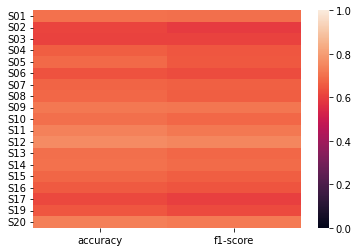

     class0 f1-score  class1 f1-score
S01         0.789474         0.489362
S02         0.734694         0.285714
S03         0.718367         0.355140
S04         0.772563         0.350515
S05         0.798450         0.297297
S06         0.756757         0.307692
S07         0.770428         0.438095
S08         0.782288         0.404040
S09         0.805861         0.485437
S10         0.792727         0.435644
S11         0.826772         0.450000
S12         0.838462         0.543478
S13         0.795455         0.425532
S14         0.793893         0.460000
S15         0.780669         0.391753
S16         0.764045         0.363636
S17         0.744939         0.258824
S19         0.760148         0.329897
S20         0.818182         0.500000


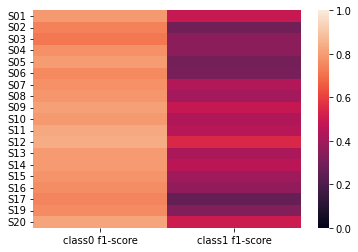

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [8]:
model.return_pairwise_weights().shape

(32,)